<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/labs/lab_10/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [2]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [3]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [4]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281_2022/main/labs/lab_10/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [5]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


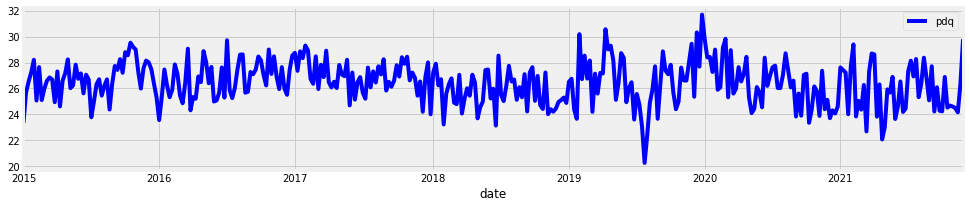

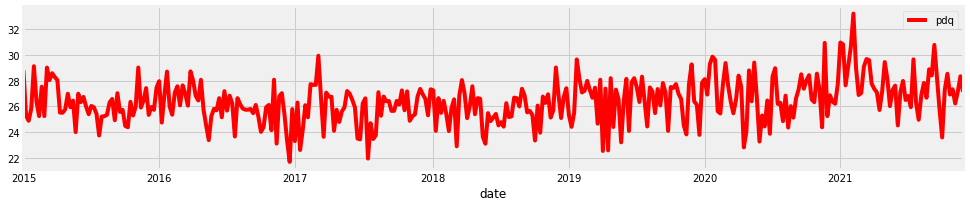

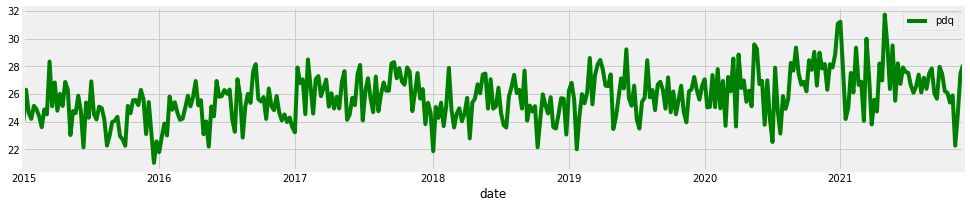

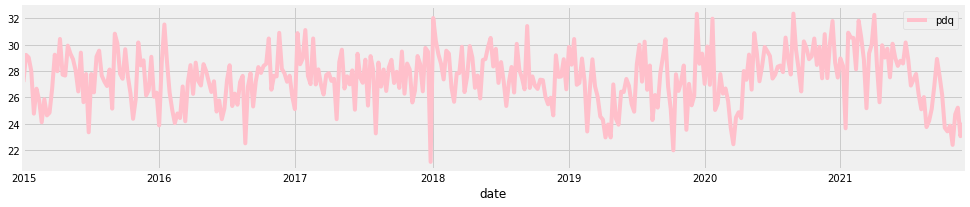

In [6]:
y_s1.plot(figsize=(15, 3),color = 'blue')
y_s2.plot(figsize=(15, 3),color = 'red')
y_s3.plot(figsize=(15, 3),color = 'green')
y_s4.plot(figsize=(15, 3),color = 'pink')
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realizar un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


**Realizar un análisis exploratorio de la serie temporal escogida**

In [7]:
y_s2.head()


,pdq
date,
2015-01-04,28.803030
2015-01-11,25.270073
2015-01-18,24.867257
2015-01-25,25.828571
2015-02-01,29.120000


In [8]:
y_s2.sort_values(['date'])

,pdq
date,
2015-01-04,28.803030
2015-01-11,25.270073
2015-01-18,24.867257
2015-01-25,25.828571
2015-02-01,29.120000
...,...
2021-10-31,27.324503
2021-11-07,26.211009
2021-11-14,27.153153


In [9]:
y_s2.describe().T

,count,mean,std,min,25%,50%,75%,max
pdq,361.0,26.389151,1.677889,21.66087,25.371134,26.40625,27.361538,33.220588


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


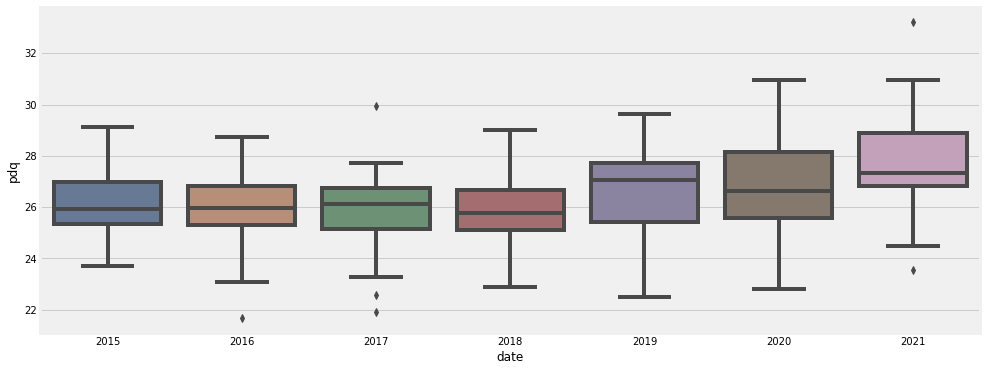

In [10]:
# diagrama de caja y bigotes
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y_s2.index.year, y_s2.pdq, ax=ax)
plt.show()

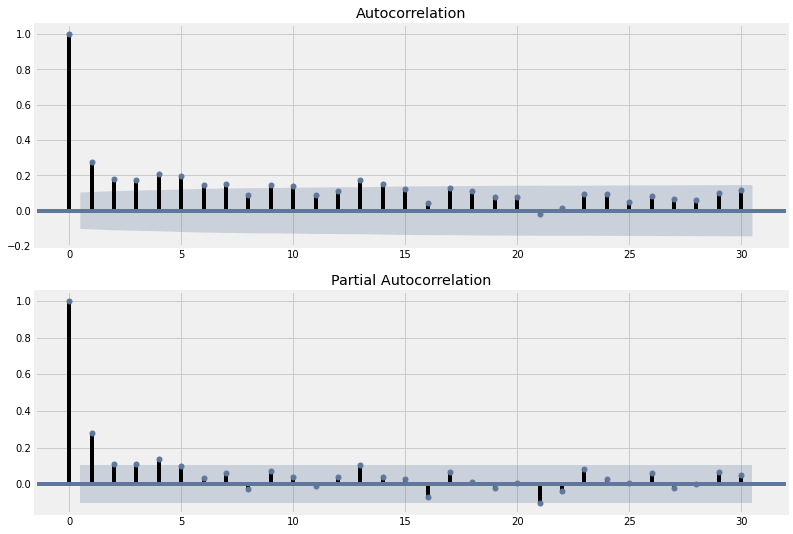

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(y_s2.pdq, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(y_s2.pdq, ax=pyplot.gca(), lags = 30)
pyplot.show()

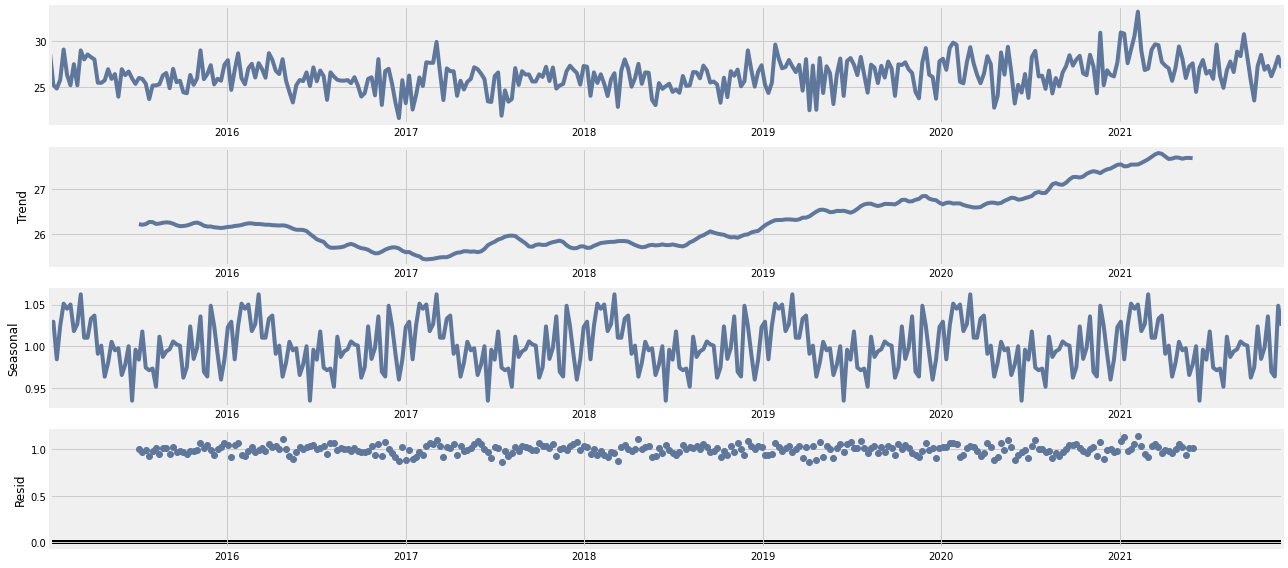

In [12]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s2, model='multiplicative')
fig = decomposition.plot()
plt.show()

**Aplicar el modelo de pronóstico  SARIMA(p,d,q)x(P,D,Q,S) , probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.**

In [13]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [14]:
# iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s2,target_date)
        frames.append(df_metrics)
    except:
        pass

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [15]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.3551,3.4263,1.8510,0.0478,0.0476,0.0488,0.0461,0.0486,"SARIMA_(1,1,0)X(1,0,1,12)"
0,1.3567,3.4359,1.8536,0.0478,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(0,0,1,12)"
0,1.3584,3.4565,1.8592,0.0479,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(1,0,0,12)"
0,1.3588,3.5038,1.8718,0.0478,0.0477,0.0489,0.0462,0.0487,"SARIMA_(1,1,0)X(0,0,0,12)"
0,1.3703,3.1981,1.7883,0.0491,0.0490,0.0494,0.0474,0.0492,"SARIMA_(0,1,0)X(0,0,0,12)"
...,...,...,...,...,...,...,...,...,...
0,3.1468,13.4226,3.6637,0.1107,0.1098,0.1133,0.1069,0.1192,"SARIMA_(1,1,0)X(1,1,0,12)"
0,24.1010,618.8685,24.8771,0.8744,0.7022,0.8681,0.8436,1.6744,"SARIMA_(0,0,0)X(0,0,1,12)"
0,24.5214,625.0162,25.0003,0.8893,0.7163,0.8833,0.8581,1.6908,"SARIMA_(0,0,1)X(0,0,1,12)"
0,27.5504,762.9708,27.6219,0.9932,0.7814,0.9924,0.9585,1.9794,"SARIMA_(0,0,1)X(0,0,0,12)"


In [16]:
param = [(1,1,0),(1,0,1,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y_s2,target_date)
best_model = sarima_model.df_testig(y_s2,target_date)
best_model.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,y,yhat
2021-01-03,30.967742,26.976727
2021-01-10,30.833333,27.432895
2021-01-17,27.629032,27.297904
2021-01-24,29.114754,27.216431
2021-01-31,30.606061,27.286228


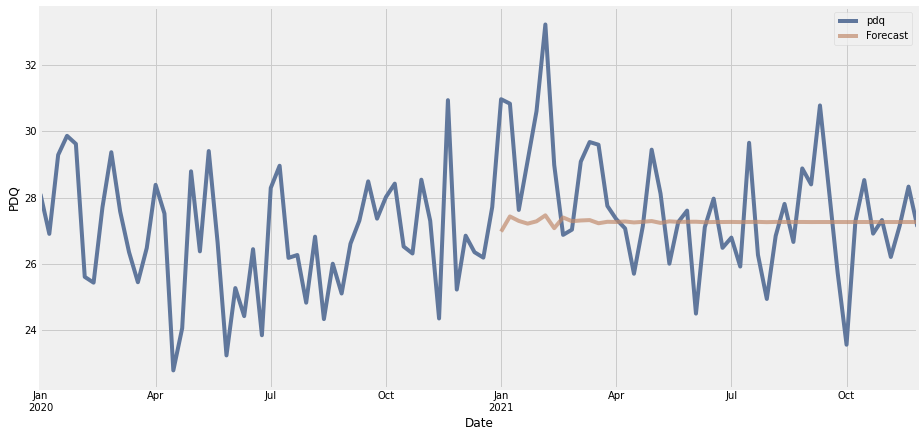

In [17]:
# graficar mejor modelo

preds = best_model['yhat']
ax = y_s2['2020':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('PDQ')
plt.legend()
plt.show()

Conclusión: a pesar de ser la mejor configuracion segun mae y mape que minimiza el modelo , no es un buen modelo SARIMA

---



**Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.**

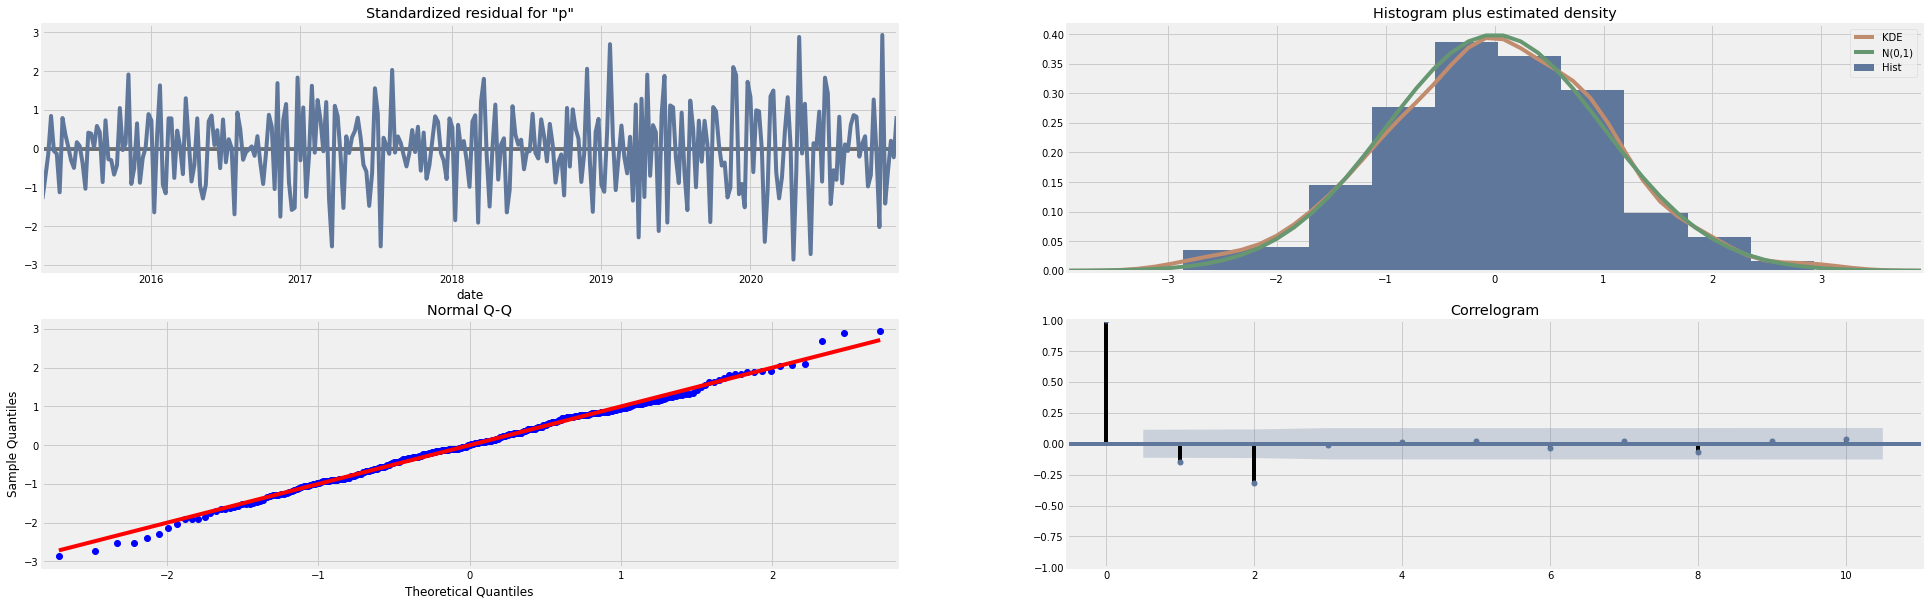

In [28]:
# resultados del error 
model_fit.plot_diagnostics(figsize=(30, 10))
plt.show()

Gráfico standarized residual: La serie de tiempo corresponde a una serie estacionaria que oscila entorno al cero, por lo que es un ruido blanco \\
gráfico histogram plus estimated density: notemos que es muy similar al histograma de una variable (ruido blanco) \\
gráfico normal QQ: podriamos decir que tiene un buen ajuste lineal \\



3. Resuelva el ejercicio anterior utilizando la librería de `Prophet`.

In [19]:
from prophet import Prophet

In [20]:
y_s2

,pdq
date,
2015-01-04,28.803030
2015-01-11,25.270073
2015-01-18,24.867257
2015-01-25,25.828571
2015-02-01,29.120000
...,...
2021-10-31,27.324503
2021-11-07,26.211009
2021-11-14,27.153153


In [21]:
target_date = '2021-01-01'

# crear conjunto de entrenamiento y de testeo
mask_ds = y_s2.index < target_date

y_s2_train = y_s2[mask_ds]
y_s2_test = y_s2[~mask_ds]

In [22]:
y_train_prophet = y_s2_train.reset_index()
y_train_prophet.columns = ["ds","y"]

y_test_prophet = y_s2_test.reset_index()
y_test_prophet.columns = ["ds","y"]

In [23]:
# model
m = Prophet()
m.fit(y_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb42s8p67/rr_9dnyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb42s8p67/k23fbvhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26658', 'data', 'file=/tmp/tmpb42s8p67/rr_9dnyy.json', 'init=/tmp/tmpb42s8p67/k23fbvhw.json', 'output', 'file=/tmp/tmpb42s8p67/prophet_modelpp26akss/prophet_model-20221112024354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:43:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:43:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
# forecast
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)[['ds', 'yhat']]
forecast.tail()

,ds,yhat
1768,2024-12-22,28.216933
1769,2024-12-23,28.230594
1770,2024-12-24,28.252182
1771,2024-12-25,28.281099
1772,2024-12-26,28.316603


In [25]:
# metrics
result = y_test_prophet.merge(forecast,on = 'ds',how='inner')
summary_metrics(result)

,mae,mse,rmse,mape,maape,wmape,mmape,smape
0,1.2731,2.9623,1.7211,0.0447,0.0446,0.0459,0.0432,0.0456


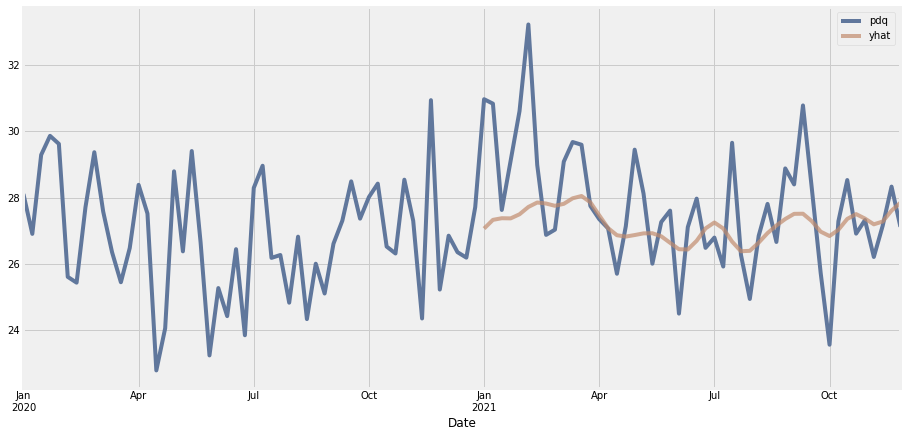

In [26]:
preds = result[['ds','yhat']].set_index("ds")
ax = y_s2['2020':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
plt.legend()
plt.show()